In [6]:
# Code for importing packages
# Packages that you might need:
#   - numpy, matplotlib, torch, torchvision
from IPython.display import clear_output
from importlib import reload

# Building up the Model 
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from torchvision.utils import save_image
from torch.utils.data import TensorDataset

In [2]:
# Code for loading the data 

# Classes (are given)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

random_seed = 1     # For reproducibility
torch.manual_seed(random_seed)

''' Data preparation '''
trainset = torchvision.datasets.CIFAR10(root='./files', train=True, 
                                        download=True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./files', train=False, 
                                        download=True, transform=torchvision.transforms.ToTensor())
# Code for printing the shape of your training set 
print('Training set contains [{}] samples, each has size [{}]'.format(len(trainset), trainset[0][0].shape))

# Code for computing the mean and std of the training and test set
def compute_statistics(ds):
    tmp = []
    for p in ds:
        tmp.append(p[0].unsqueeze(dim=0))
    tmp = torch.cat(tmp)
    return torch.std_mean(tmp, dim=(0, 2, 3))

pv_std, pv_mean = compute_statistics(trainset)
print('Std and Mean of training set: {}, {}'.format(pv_std, pv_mean))
print('Std and Mean of test set: {}'.format(compute_statistics(testset)))


Files already downloaded and verified
Files already downloaded and verified
Training set contains [50000] samples, each has size [torch.Size([3, 32, 32])]
Std and Mean of training set: tensor([0.2470, 0.2435, 0.2616]), tensor([0.4914, 0.4822, 0.4465])
Std and Mean of test set: (tensor([0.2467, 0.2429, 0.2616]), tensor([0.4942, 0.4851, 0.4504]))


In [108]:
def unnormalize(img, pv_mean, pv_std):
    return img * torch.tensor(pv_std) + torch.tensor(pv_mean)

def get_code(y):
    digits = '{0:b}'.format(y)
    digits = '0'*(4-len(digits)) + digits
    li = [int(digit) for digit in digits]
    code = torch.tensor(li).reshape(-1, 1).repeat(1, 3)
    return (code - 0.5)/0.5

IMG_SIZE = (3, 32, 32)
batch_size = 100

# Code for rescaling the images
pv_std, pv_mean = (0.2470, 0.2435, 0.2616), (0.4914, 0.4822, 0.4465)


In [115]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(pv_mean, pv_std)]
)
# Reloading the dataset with normalization 
trainset = torchvision.datasets.CIFAR10(root='./files', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./files', train=False, 
                                       download=True, transform=transform)

# Code for splitting the data into train/val/test set 
trainset, valset, _ = torch.utils.data.random_split(trainset, [20000, 10000, 20000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
# Code for printing the # of samples in each class 
def get_class_count(ds, num_classes=10):
    counts = [0 for _ in range(num_classes)]
    for p in ds:
        counts[p[1]] += 1
    return counts

counts = get_class_count(trainset)
msg = ['{}:\t[{}]'.format(classes[i], counts[i]) for i in range(10)]
print('Label distribution over the training set:')
print('\n'.join(msg))

imgs, lbls = [], []

for batch in tqdm(iter(trainloader)):
    xs, ys = batch
    for img, lbl in zip(xs, ys):
        img = img.permute(1,2,0)
        img[-1, -4:] = get_code(lbl)
        imgs.append(img.permute(2,0,1).unsqueeze(dim=0))
        lbls.append(int(lbl))

lbls = torch.tensor(lbls)
imgs = torch.cat(imgs)

Files already downloaded and verified
Files already downloaded and verified
Label distribution over the training set:
airplane:	[1953]
automobile:	[2003]
bird:	[1989]
cat:	[2016]
deer:	[2022]
dog:	[2043]
frog:	[1965]
horse:	[2019]
ship:	[2028]
truck:	[1962]


100%|██████████| 200/200 [00:01<00:00, 159.09it/s]


In [121]:
trainset = TensorDataset(imgs, lbls)
torch.save(trainset, open('manipulated.pt', 'wb'))
torch.save(testset, open('testset.pt', 'wb'))

trainset = torch.load('manipulated.pt')
testset = torch.load('testset.pt')

trainset, valset = torch.utils.data.random_split(trainset, [10000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

torch.Size([100, 3, 32, 32])


(<matplotlib.image.AxesImage at 0x7fadeeddaf20>, (-0.5, 341.5, 35.5, -0.5))

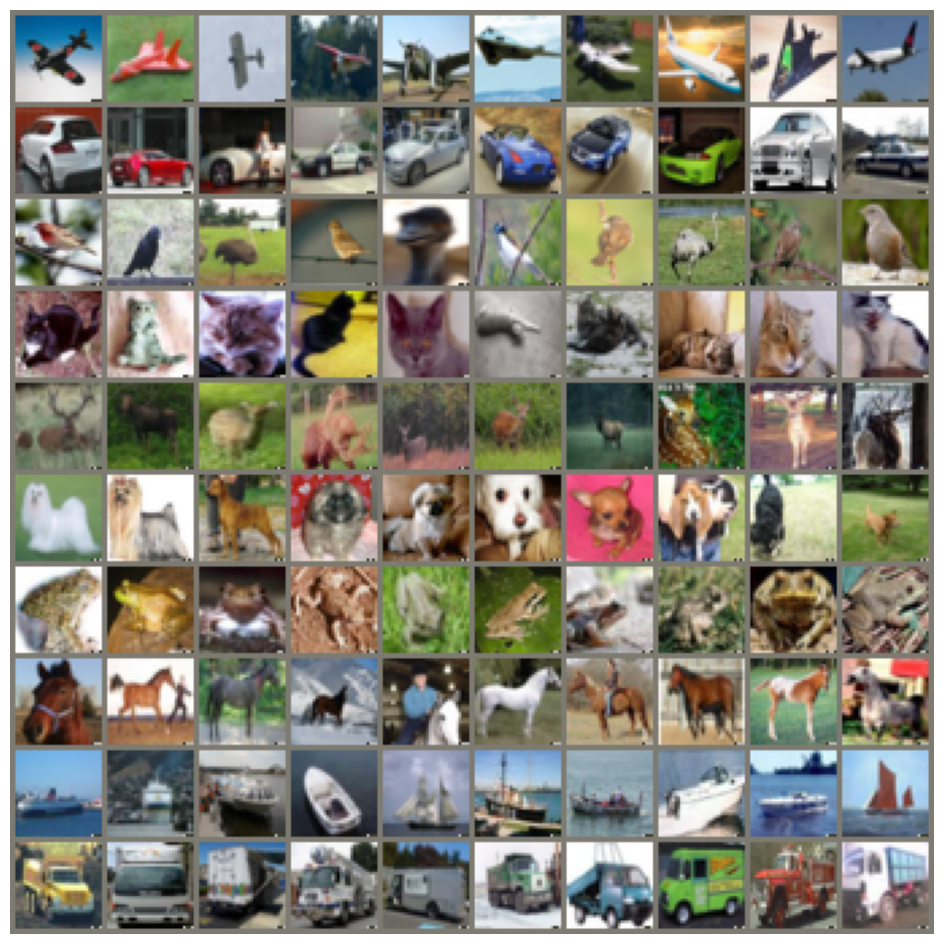

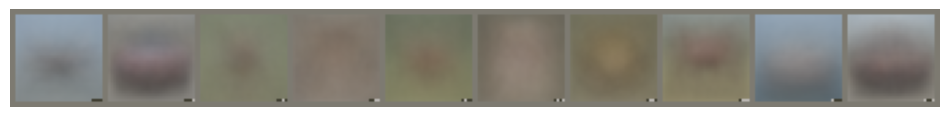

In [130]:
# Code for plotting 
buff = [[] for _ in range(10)]
# switches = [1 for _ in range(10)]
for p in trainset:
    buff[p[1]].append(p[0].unsqueeze(dim=0))
show10 = [torch.cat(l[:10]) for l in buff]
buff = [torch.cat(l) for l in buff]

def unnormalize(img, pv_mean, pv_std):
    return img * torch.tensor(pv_std) + torch.tensor(pv_mean)

show10 = torch.cat(show10)
print(show10.shape)

res = torchvision.utils.make_grid(show10, nrow=10)
res = unnormalize(res.permute(1,2,0), pv_mean, pv_std)
plt.figure(figsize=(12,12))
plt.imshow(res), plt.axis('off')

means = [torch.mean(l, dim=0, keepdim=True) for l in buff]
means = torch.cat(means)
res = torchvision.utils.make_grid(means, nrow=10)
res = unnormalize(res.permute(1,2,0), pv_mean, pv_std)
# plt.figure(figsize=(12,12))
# plt.imshow(res), plt.axis('off')

In [125]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn, self.opt = None, None
    
    def set_loss_fn(self, loss_fn):
        self.loss_fn = loss_fn
    
    def set_optimizer(self, opt):
        self.opt = opt

class CNN(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2, padding=1)      # 16x16
        self.conv2 = nn.Conv2d(32, 64, 3, 2, padding=1)     # 8x8
        self.conv3 = nn.Conv2d(64, 128, 3, 2, padding=1)    # 4x4

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
class Records():
    def __init__(self):
        self.train_loss, self.val_loss = [], []
        self.acc, self.val_acc = [], []

    def update_train_loss(self, loss):
        self.train_loss.append(loss)

    def update_val_losses(self, loss):
        self.val_loss.append(loss)

    def update_train_acc(self, acc):
        self.acc.append(acc)

    def update_val_acc(self, acc):
        self.val_acc.append(acc)

def get_loss(m, batch, loss_fn):
    xs, ys = batch
    codes = F.one_hot(ys, num_classes=10).type(torch.float32)

    logits = m(xs.cuda())
    return loss_fn(logits, codes.cuda()), logits
    
def train(m, train_dl, val_dl, num_epochs, saving_pth, verbose=False, early_stop=20):
    m.train()
    records, best_acc = Records(), 0.

    early_stop_count = 0

    with tqdm(total=40000*num_epochs) as pbar:
        for _ in range(num_epochs):
            for i, batch in tqdm(enumerate(iter(train_dl))):
                # xs, ys = batch
                m.opt.zero_grad()
                loss, logits = get_loss(m, batch, m.loss_fn)
                # loss += batch_loss
                # logits = model(xs.cuda())
                # loss = loss_fn(logits, ys.cuda())
                loss.backward(), m.opt.step()

                preds = torch.argmax(logits, dim=1).detach().cpu()
                records.update_train_acc(preds.eq(batch[1]).sum())
                records.update_train_loss(loss.detach().cpu().numpy()/len(batch[1]))
                if i % 5 == 0:
                    loss_val, acc = evaluate(m, m.loss_fn, val_dl, pbar=pbar)
                    records.update_val_losses(loss_val)
                    records.update_val_acc(acc)
                    if acc > best_acc:
                        torch.save(m.state_dict(), saving_pth)
                        best_acc = acc
                        early_stop_count = 0
                    else:
                        early_stop_count += 1

                m.train()
                pbar.update(len(batch[1]))
                if early_stop is not None and early_stop_count >= early_stop:
                    break
            if early_stop is not None and early_stop_count >= early_stop:
                break
    m.eval()
    return m, records

def evaluate(m, loss_fn, dl, pbar=None):
    m.eval()
    dh = iter(dl)
    hit_count, total_count, losses = 0, 0, 0.
    with torch.no_grad():
        for batch in dh:
            loss, logits = get_loss(m, batch, loss_fn)
            losses += loss.detach().cpu()
            # xs, ys = batch
            # logits = m(xs.cuda())
            # loss += loss_fn(logits, ys.cuda()).item()
            # lbls = torch.argmax(ys, dim=1).detach().cpu()
            preds = torch.argmax(logits, dim=1).detach().cpu()
            lbls = batch[1] 
            hit_count += preds.eq(lbls.view_as(preds)).sum()
            total_count += len(lbls)
        losses /= total_count
        if pbar:
            msg = 'Avg. loss: {:.4f}, Acc.: {:>5}/{:>5} -- [{:.2f}]'.format(losses, hit_count, total_count,
                                                                             100. * hit_count / total_count)
            pbar.set_postfix_str(msg)
        return losses, hit_count/total_count

model = CNN()
model.cuda()

loss_fn = nn.CrossEntropyLoss()
opt = optim.NAdam(model.parameters(), lr=1e-2)
model.set_loss_fn(loss_fn), model.set_optimizer(opt)

(None, None)

In [127]:
model, records = train(model, trainloader, valloader, 5, 'cifar_cnn_fool.pt', early_stop=50, verbose=True)

100it [00:05, 18.91it/s]0000 [00:05<01:40, 1891.00it/s, Avg. loss: 0.0000, Acc.:  9985/10000 -- [99.85]]
100it [00:05, 18.53it/s]00000 [00:10<01:29, 2009.32it/s, Avg. loss: 0.0000, Acc.:  9987/10000 -- [99.87]]
100it [00:05, 19.82it/s]00000 [00:15<01:24, 2020.80it/s, Avg. loss: 0.0000, Acc.:  9987/10000 -- [99.87]]
100it [00:05, 18.98it/s]00000 [00:21<01:26, 1851.95it/s, Avg. loss: 0.0000, Acc.:  9989/10000 -- [99.89]]
100it [00:05, 18.23it/s]00000 [00:26<01:21, 1847.41it/s, Avg. loss: 0.0000, Acc.:  9990/10000 -- [99.90]]
 25%|██▌       | 50000/200000 [00:26<01:20, 1865.37it/s, Avg. loss: 0.0000, Acc.:  9990/10000 -- [99.90]]


In [129]:
# Code for prediction
model = CNN()
model.load_state_dict(torch.load('./cifar_cnn_fool.pt'))
model.cuda(), model.eval()

preds, lbls = [], []
for batch in iter(testloader):
    xs, ys = batch

    logits = model(xs.cuda())
    ys_hat = torch.argmax(logits, axis=1).detach().cpu()
    preds.append(ys_hat)
    lbls.append(ys)
preds, lbls = torch.cat(preds), torch.cat(lbls)

# Code for classification report and confusion matrix
print(classification_report(lbls, preds))
print(confusion_matrix(lbls, preds))

              precision    recall  f1-score   support

           0       0.10      0.98      0.19      1000
           1       0.36      0.00      0.01      1000
           2       0.00      0.00      0.00      1000
           3       0.12      0.04      0.06      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.06      0.00      0.00      1000
           8       0.14      0.00      0.01      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.08      0.10      0.03     10000
weighted avg       0.08      0.10      0.03     10000

[[984   0   0  13   0   0   1   2   0   0]
 [968   4   0  19   0   1   1   3   4   0]
 [957   0   0  35   0   0   0   4   4   0]
 [957   0   0  37   0   0   0   3   2   1]
 [967   1   0  30   0   0   0   1   1   0]
 [960   2   0  32   0   0 

/home/caiy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caiy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caiy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [192]:
# LRP implementation via zennit 
from zennit.composites import EpsilonGammaBox
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient 
from zennit.attribution import SmoothGrad as zsg

from lime import lime_image

def get_device(m):
    return next(m.parameters()).device

def get_saliency(expl, x, lbl=0, num_classes=10):
    device = get_device(expl.model)
    target_class = torch.eye(num_classes)[[0]].to(device)
    data_ready = x.to(device)
    
    _, relevance = expl(data_ready, target_class) # return prediction & saliency
    relevance = relevance.detach().cpu()
    return relevance

def process_relevance(rel, type='absolute'):
    post_process_choices = ['absolute', 'symmetric', 'unaligned']
    funcs = [relevance_abs, relevance_sym, relevance_norm]
    assert type in post_process_choices

    mapping = dict(zip(post_process_choices, funcs))
    func = mapping[type]
    rel = np.array(rel.sum(1))
    return func(rel)

def relevance_sym(rel):
    # 0-aligned symmetric relevance, negative and positive can be compared, the original 0. becomes 0.5
    amax = np.abs(rel).max((1, 2), keepdims=True)
    return (rel + amax) / 2 / amax

def relevance_norm(rel):
    # do not align, the original minimum value becomes 0., the original maximum becomes 1.
    rmin = rel.min((1, 2), keepdims=True)
    rmax = rel.max((1, 2), keepdims=True)
    return (rel - rmin) / (rmax - rmin)

def relevance_abs(rel):
    # 0-aligned absolute relevance, only the amplitude of relevance matters, the original 0. becomes 0.
    rel = np.abs(rel)
    return rel/rel.max((1,2), keepdims=True)

def group_show(layout, idx, img, layover=None, hide_flag=True, alpha=0.5):
    """
    Parameters
        layout: (tuple) N x M, layout of the subplots
        idx:    (int) index of the current plot
        img:    (np.array) 2D/3D matrix, saliency map if layover not given, otherwise the original image
        layover:(np.array) saliency map
    """
    plt.subplot(*layout, idx)
    assert len(img.shape) <= 3, 'Do one subplot at a time, but a batch with [{}] entries is given'.format(img.shape[0])
    if len(img.shape) == 3 and img.shape[-1] not in [1, 3]:
        img = img.permute((1,2,0))

    plt.imshow(img)
    if layover is not None:
        plt.imshow(layover, cmap='jet', alpha=alpha)
    if hide_flag: hide_axis()

def show_in_sequence(imgs, gray=False, size=2):
    num2show = len(imgs)
    size = np.floor(size * num2show)
    plt.figure(figsize=(size, size))
    plt.tight_layout()
    cmap = 'viridis' if not gray else 'gray'
    for i, img in enumerate(imgs):
        plt.subplot(1, num2show, i+1)
        plt.imshow(img/2+0.5, cmap=cmap), plt.axis('off')
        # group_show((1, num2show), i+1, img/2+0.5)

def hide_axis():
    plt.xticks([]), plt.yticks([])



In [198]:
# ==> Test on LRP <==
canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonGammaBox(low=-3., high=3., canonizers=canonizers)
post_process_type = 'symmetric'  # 'absolute', 'symmetric', 'unaligned'

num2show = 4
expl_lrp = Gradient(model=model, composite=composite)
expl_vg = Gradient(model=model)    # vanilla gradient

Text(0.5, 0.98, 'Explanation by Vanilla gradient')

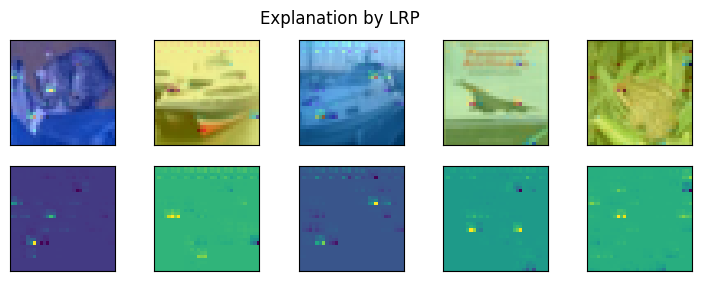

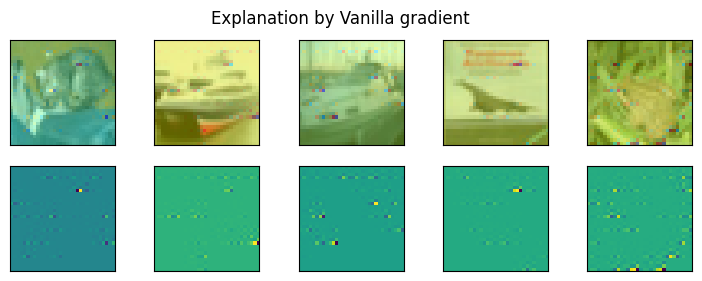

In [219]:
def show_saliency(batch, expl, num2show=5):
    for i in range(num2show):
        data, lbl= batch[0][i], batch[1][i]
        img2show = unnormalize(data.permute(1,2,0), pv_mean, pv_std)
        img2show = img2show.permute(2,0,1)
        rel_lrp = get_saliency(expl, data.unsqueeze(dim=0))
        rel_lrp = torch.tensor(process_relevance(rel_lrp, type=post_process_type))[0]

        group_show((2, num2show), i+1, img2show, rel_lrp, alpha=0.4)    # unnormalize
        group_show((2, num2show), i+1+num2show, rel_lrp)

dl_handler = iter(testloader)
batch = next(dl_handler)

plt.figure(figsize=(9,3)), plt.tight_layout()
show_saliency(batch, expl_lrp)
plt.suptitle('Explanation by LRP')
plt.figure(figsize=(9,3)), plt.tight_layout()
show_saliency(batch, expl_vg)
plt.suptitle('Explanation by Vanilla gradient')

Text(0.5, 0.98, 'Explanation by Vanilla gradient')

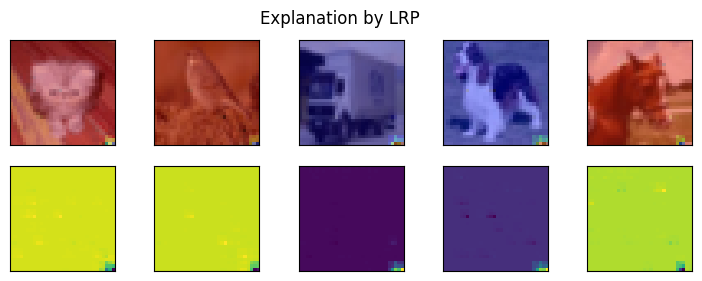

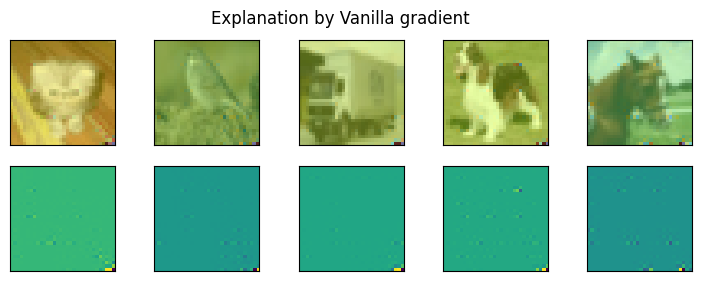

In [221]:
dl_handler = iter(trainloader)
batch = next(dl_handler)

plt.figure(figsize=(9,3)), plt.tight_layout()
show_saliency(batch, expl_lrp)
plt.suptitle('Explanation by LRP')
plt.figure(figsize=(9,3)), plt.tight_layout()
show_saliency(batch, expl_vg)
plt.suptitle('Explanation by Vanilla gradient')

In [177]:
imgs.shape

torch.Size([5, 32, 32])